# Models Analysis

In [1]:
path   = './best_weights/'
t_path = './teacher-best_weight/'

## KD Methods
KD_model_path         = path + 'KD_student_model.pt'
KD_training_hist_path = path + 'KD_training_hist.pt'

metaDistil_model_path         = path + 'MetaKD_student_model.pt'
metaDistil_training_hist_path = path + 'MetaKD_training_hist.pt'

## Teacher
bert_model_path         = t_path + 'bert-base-uncased-SST-2.pt'
bert_training_hist_path = t_path + 'bert-base-uncased-SST-2_training_hist.pt' 

roberta_model_path         = t_path + 'roberta-base-SST-2.pt'
roberta_training_hist_path = t_path + 'roberta-base-SST-2_training_hist.pt'

## Student
distilbert_model_path         = t_path + 'distilbert-base-uncased-SST-2.pt'
distilbert_training_hist_path = t_path + 'distilbert-base-uncased-SST-2_training_hist.pt'

tinybert_model_path         = t_path + 'tinybert-SST-2.pt'
tinybert_training_hist_path = t_path + 'tinybert-SST-2_training_hist.pt'



## 1) Loading test set for our SST-2 part of the GLUE dataset

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

test_dataset = load_dataset("glue", "sst2", split=["train[60000:62000]"])
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Found cached dataset glue (C:/Users/abhin/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
test_dataset

[Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 2000
 })]

In [4]:
from datasets import DatasetDict

In [5]:
test_dataset = DatasetDict({
    "test": test_dataset[0]
})

In [6]:
test_dataset

DatasetDict({
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 2000
    })
})

In [7]:
raw_test_dataset = test_dataset["test"]
raw_test_dataset[0]

{'sentence': 'manically generous ', 'label': 1, 'idx': 60000}

In [8]:
raw_test_dataset[5]['sentence']

'elegant and sly '

In [9]:
raw_test_dataset[5]['label']

1

In [10]:
raw_test_dataset[5]['idx']

60005

In [11]:
raw_test_dataset.features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive'], id=None),
 'idx': Value(dtype='int32', id=None)}

## 2) Preprocess

In [12]:
def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=True)

tokenized_datasets = test_dataset.map(tokenize_function, batched=True)
tokenized_datasets

Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-eb58b859a3e8c393.arrow


DatasetDict({
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

## 3) Preparing for Evaluation

In [13]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [14]:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["test"].column_names

['labels', 'input_ids', 'attention_mask']

In [15]:
from torch.utils.data import DataLoader

eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=20, collate_fn=data_collator
)

In [16]:
for batch in eval_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([20]),
 'input_ids': torch.Size([20, 43]),
 'attention_mask': torch.Size([20, 43])}

## 4) Loading Models

In [17]:
# id2label, label2id dicts for the outputs for the model
labels = tokenized_datasets["test"].features["labels"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [18]:
from transformers import AutoModelForSequenceClassification

## KD Methods
student = "distilbert-base-uncased"

KD_model = AutoModelForSequenceClassification.from_pretrained(
    student,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

metaDistil_model = AutoModelForSequenceClassification.from_pretrained(
    student,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

## Teacher
bert_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

roberta_model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

## Student
distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

tinybert_model = AutoModelForSequenceClassification.from_pretrained(
    "huawei-noah/TinyBERT_General_4L_312D",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

In [19]:
import torch

In [20]:
best_KD_weight = torch.load(KD_model_path)
KD_model.load_state_dict(best_KD_weight['model_state_dict'])

<All keys matched successfully>

In [21]:
best_metaDistil_weight = torch.load(metaDistil_model_path)
metaDistil_model.load_state_dict(best_metaDistil_weight['model_state_dict'])

<All keys matched successfully>

In [22]:
best_bert_weight = torch.load(bert_model_path)
bert_model.load_state_dict(best_bert_weight['model_state_dict'])

<All keys matched successfully>

In [23]:
best_roberta_weight = torch.load(roberta_model_path)
roberta_model.load_state_dict(best_roberta_weight['model_state_dict'])

<All keys matched successfully>

In [24]:
best_distilbert_weight = torch.load(distilbert_model_path)
distilbert_model.load_state_dict(best_distilbert_weight['model_state_dict'])

<All keys matched successfully>

In [25]:
best_tinybert_weight = torch.load(tinybert_model_path)
tinybert_model.load_state_dict(best_tinybert_weight['model_state_dict'])

<All keys matched successfully>

## 5) Training Plots

### 5.1) Teacher Training Plots

In [26]:
bert_training_hist   = torch.load(bert_training_hist_path)
roberta_training_hist = torch.load(roberta_training_hist_path)

#### Loss Plot

In [27]:
from train_eval_func import plotLoss

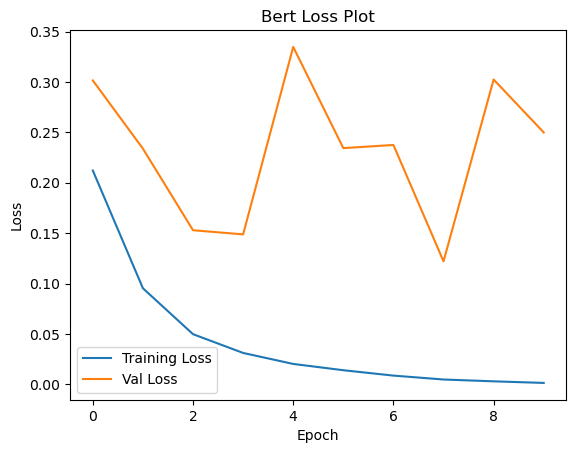

In [28]:
plotLoss(bert_training_hist['train_losses'], bert_training_hist['val_losses'], title='Bert Loss Plot')

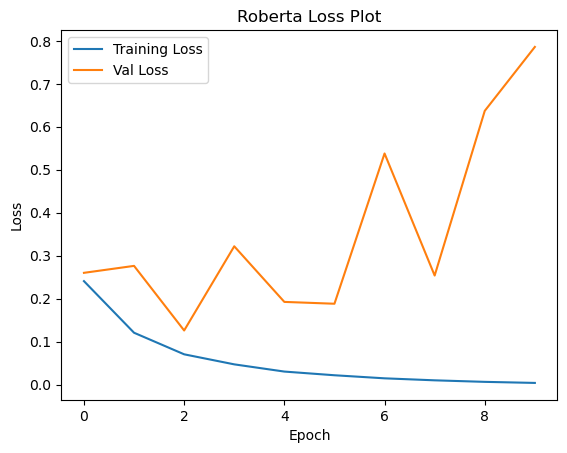

In [29]:
plotLoss(roberta_training_hist['train_losses'], roberta_training_hist['val_losses'], title='Roberta Loss Plot')

#### Accuracy Plot

In [30]:
from train_eval_func import plotAccuracy

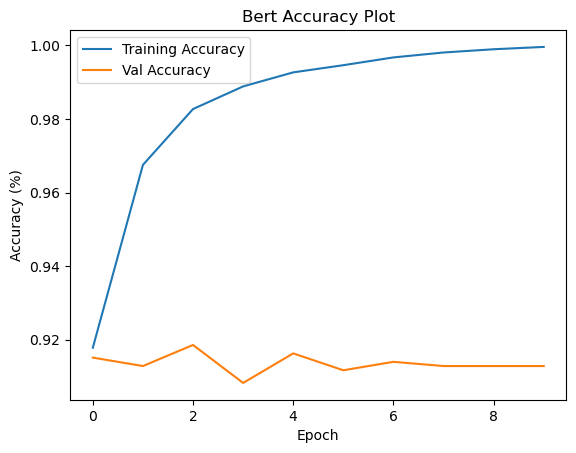

In [31]:
plotAccuracy(bert_training_hist['train_accs'], bert_training_hist['val_accs'], title='Bert Accuracy Plot')

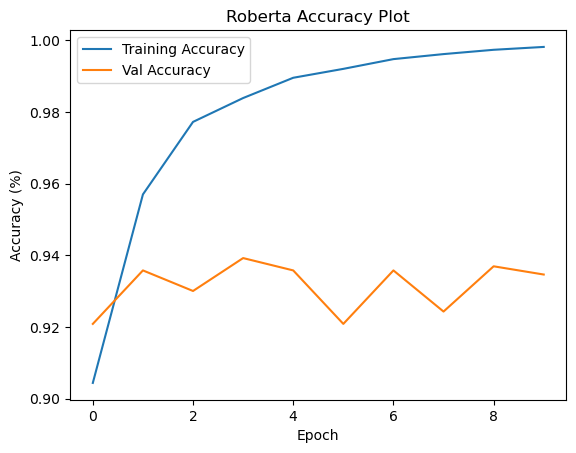

In [32]:
plotAccuracy(roberta_training_hist['train_accs'], roberta_training_hist['val_accs'], title='Roberta Accuracy Plot')

### 5.2) Pre-trained Models Fine-tuned Plots

In [33]:
distilbert_training_hist   = torch.load(distilbert_training_hist_path)
tinybert_training_hist = torch.load(tinybert_training_hist_path)

#### Loss Plot

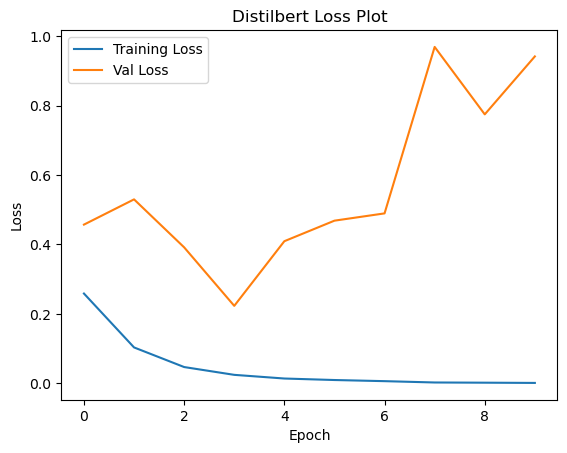

In [34]:
plotLoss(distilbert_training_hist['train_losses'], distilbert_training_hist['val_losses'], title='Distilbert Loss Plot')

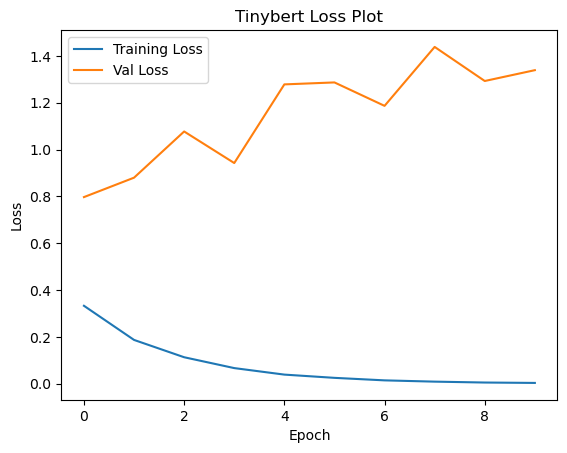

In [35]:
plotLoss(tinybert_training_hist['train_losses'], tinybert_training_hist['val_losses'], title='Tinybert Loss Plot')

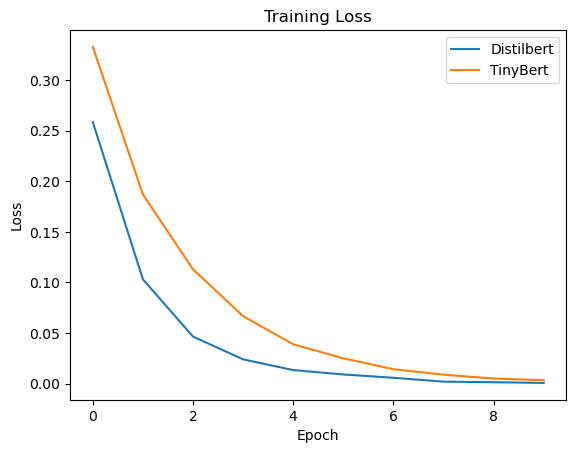

In [36]:
plotLoss(distilbert_training_hist['train_losses'], tinybert_training_hist['train_losses'], 
         ["Distilbert", "TinyBert"], 'Training Loss')

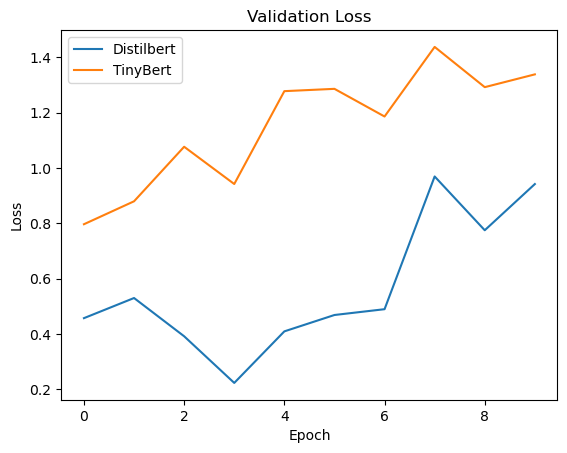

In [37]:
plotLoss(distilbert_training_hist['val_losses'], tinybert_training_hist['val_losses'], 
         ["Distilbert", "TinyBert"], 'Validation Loss')

#### Accuracy Plot

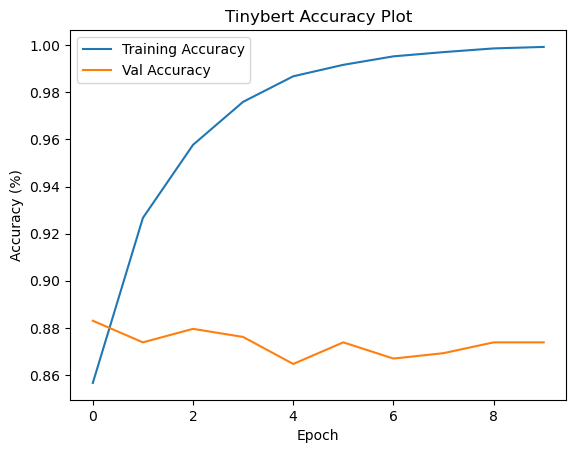

In [38]:
plotAccuracy(tinybert_training_hist['train_accs'], tinybert_training_hist['val_accs'], title='Tinybert Accuracy Plot')

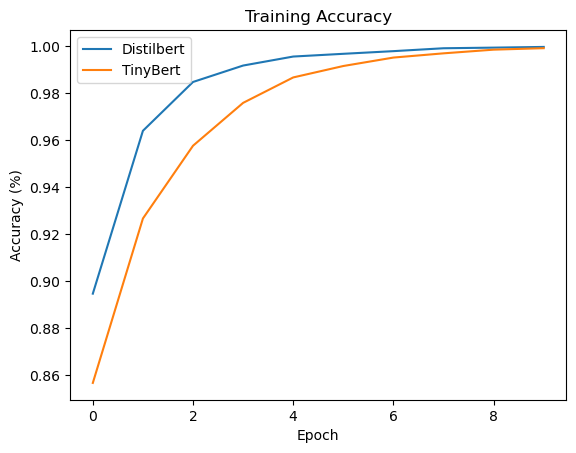

In [39]:
plotAccuracy(distilbert_training_hist['train_accs'], tinybert_training_hist['train_accs'], 
         ["Distilbert", "TinyBert"], 'Training Accuracy')

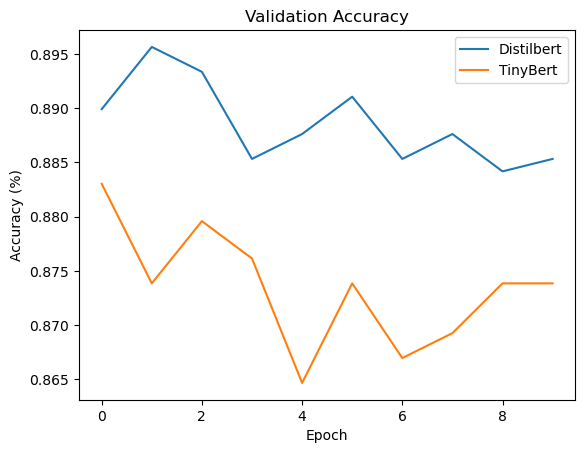

In [40]:
plotAccuracy(distilbert_training_hist['val_accs'], tinybert_training_hist['val_accs'], 
         ["Distilbert", "TinyBert"], 'Validation Accuracy')

### 5.3) Conventional Knowledge Distillation Plots

In [41]:
KD_training_hist = torch.load(KD_training_hist_path)

#### Loss Plot

In [42]:
from train_eval_func import plotLoss

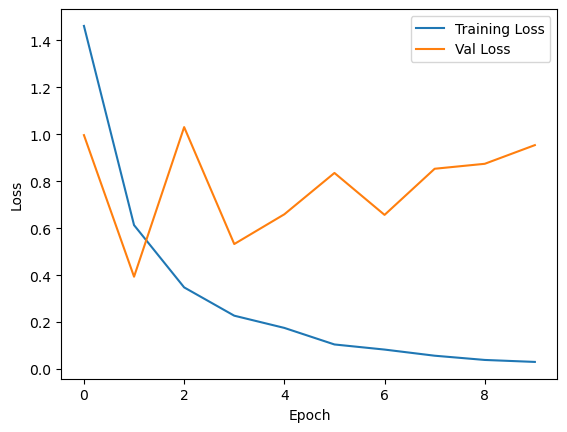

In [43]:
plotLoss(KD_training_hist['train_losses'], KD_training_hist['val_losses'])

#### Accuracy Plot

In [44]:
from train_eval_func import plotAccuracy

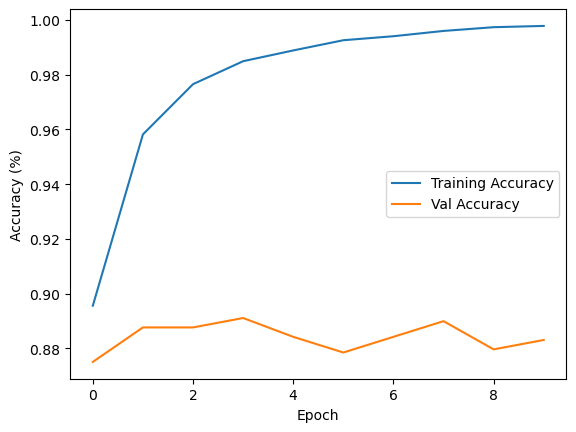

In [45]:
plotAccuracy(KD_training_hist['train_accs'], KD_training_hist['val_accs'])

### 5.4) MetaDistil Plots

In [46]:
metaDistil_training_hist = torch.load(metaDistil_training_hist_path)

#### Loss Plot

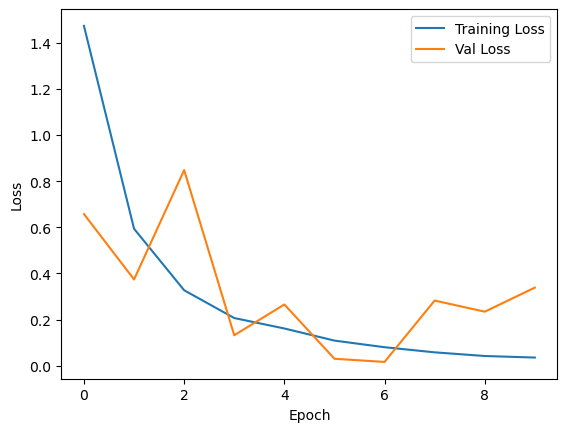

In [47]:
plotLoss(metaDistil_training_hist['train_losses'], metaDistil_training_hist['val_losses'])

#### Accuracy Plot

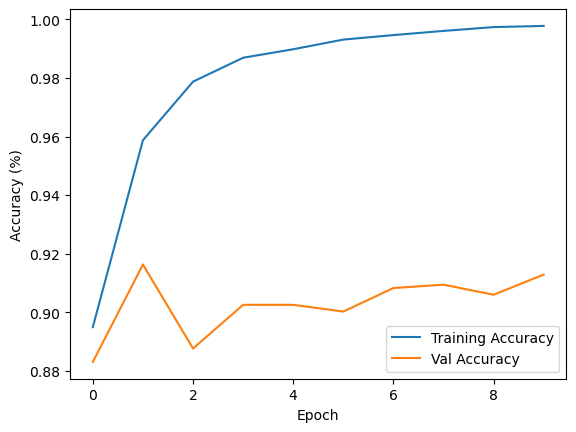

In [48]:
plotAccuracy(metaDistil_training_hist['train_accs'], metaDistil_training_hist['val_accs'])

### 5.5) Comparision Plots

#### Training Loss Plot

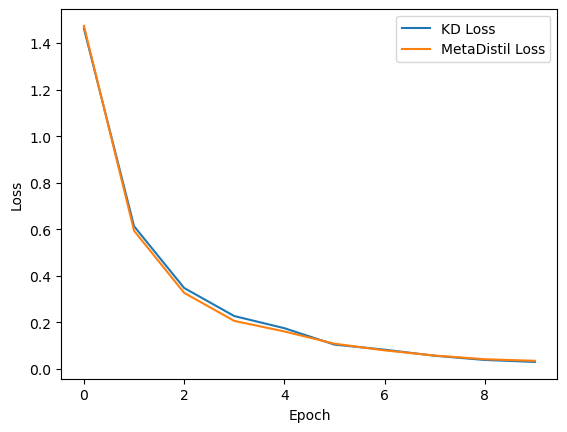

In [49]:
plotLoss(KD_training_hist['train_losses'], metaDistil_training_hist['train_losses'], ["KD Loss", "MetaDistil Loss"])

#### Val Loss Plot

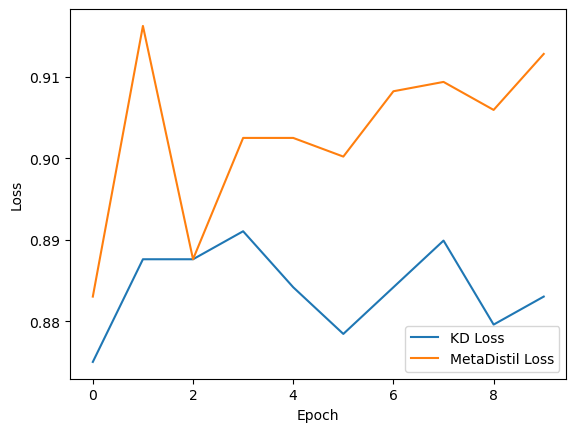

In [50]:
plotLoss(KD_training_hist['val_accs'], metaDistil_training_hist['val_accs'], ["KD Loss", "MetaDistil Loss"])

#### Training Accuracy Plot

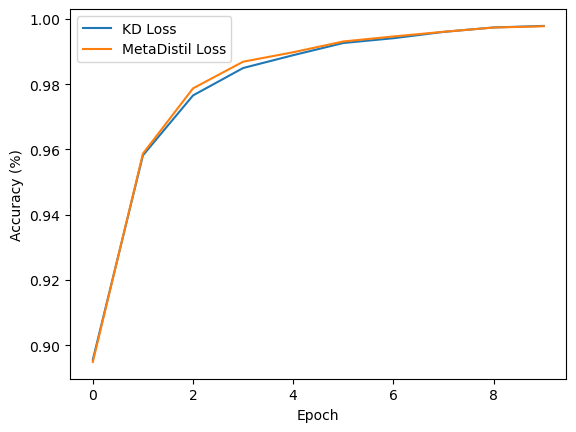

In [51]:
plotAccuracy(KD_training_hist['train_accs'], metaDistil_training_hist['train_accs'], ["KD Loss", "MetaDistil Loss"])

#### Val Accuracy Plot

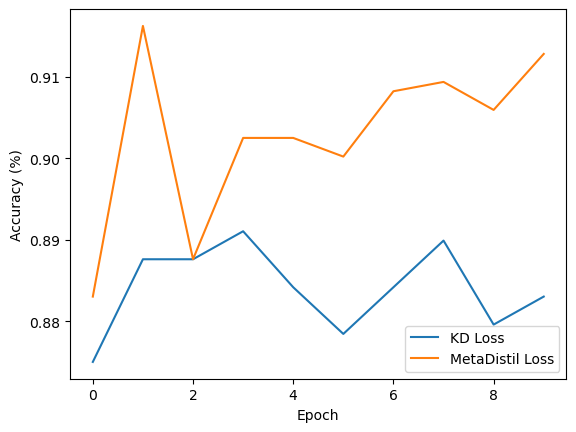

In [52]:
plotAccuracy(KD_training_hist['val_accs'], metaDistil_training_hist['val_accs'], ["KD Loss", "MetaDistil Loss"])

## 6) Training Time Summary

In [53]:
from tabulate import tabulate

In [54]:
bert_total_train_time = bert_training_hist['total_train_time'] / 3600
roberta_total_train_time = roberta_training_hist['total_train_time'] / 3600

distilbert_total_train_time = distilbert_training_hist['total_train_time'] / 3600
tinybert_total_train_time = tinybert_training_hist['total_train_time'] / 3600

KD_total_train_time = KD_training_hist['total_train_time'] / 3600
metaDistil_total_train_time = metaDistil_training_hist['total_train_time'] / 3600

In [55]:
total_train_data = [
    ["Bert", bert_total_train_time],
    ["Roberta", roberta_total_train_time],
    ["Distilbert", distilbert_total_train_time],
    ["Tinybert", tinybert_total_train_time],
    ["KD", KD_total_train_time],
    ["MetaDistil", metaDistil_total_train_time]
]
 
total_train_head = ["Methods", "Total Training Time"]

print(tabulate(total_train_data, headers=total_train_head, tablefmt="grid"), end="\n\n")

+------------+-----------------------+
| Methods    |   Total Training Time |
+============+=======================+
| Bert       |             1.11441   |
+------------+-----------------------+
| Roberta    |             1.22191   |
+------------+-----------------------+
| Distilbert |             0.308156  |
+------------+-----------------------+
| Tinybert   |             0.0986935 |
+------------+-----------------------+
| KD         |             0.523901  |
+------------+-----------------------+
| MetaDistil |             1.21618   |
+------------+-----------------------+



## 7) Evaluation

In [56]:
from train_eval_func import eval_loop

In [57]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [58]:
## KD Methods
KD_model.to(device)
metaDistil_model.to(device)

## Teachers
bert_model.to(device)
roberta_model.to(device)

## Students
distilbert_model.to(device)
tinybert_model.to(device)

device

device(type='cuda')

### KD Model Accuracy

In [59]:
KD_acc = eval_loop(KD_model, eval_dataloader, device)[0]['accuracy']
KD_acc

0.929

### MetaDistil Model Accuracy

In [60]:
metaDistil_acc = eval_loop(metaDistil_model, eval_dataloader, device)[0]['accuracy']
metaDistil_acc

0.935

### Bert Model Accuracy

In [61]:
bert_acc = eval_loop(bert_model, eval_dataloader, device)[0]['accuracy']
bert_acc

0.9535

### Roberta Model Accuracy

In [62]:
roberta_acc = eval_loop(roberta_model, eval_dataloader, device)[0]['accuracy']
roberta_acc

0.4955

### Distilbert Model Accuracy

In [63]:
distilbert_acc = eval_loop(distilbert_model, eval_dataloader, device)[0]['accuracy']
distilbert_acc

0.933

### Tinybert Model Accuracy

In [64]:
tinybert_acc = eval_loop(tinybert_model, eval_dataloader, device)[0]['accuracy']
tinybert_acc

0.9245

### Accuracy Summary

In [65]:
t_data = [
    ["Bert", bert_acc],
    ["Roberta", roberta_acc]
]
 
t_head = ["Model", "Accuracy"]

print("Teacher")
print(tabulate(t_data, headers=t_head, tablefmt="grid"), end="\n\n")


s_data = [
    ["Distilbert", distilbert_acc],
    ["Tinybert", tinybert_acc],
    ["KD", KD_acc],
    ["MetaDistil", metaDistil_acc]
]
 
s_head = ["Methods", "Accuracy"]

print("Student")
print(tabulate(s_data, headers=s_head, tablefmt="grid"))


Teacher
+---------+------------+
| Model   |   Accuracy |
+=========+============+
| Bert    |     0.9535 |
+---------+------------+
| Roberta |     0.4955 |
+---------+------------+

Student
+------------+------------+
| Methods    |   Accuracy |
+============+============+
| Distilbert |     0.933  |
+------------+------------+
| Tinybert   |     0.9245 |
+------------+------------+
| KD         |     0.929  |
+------------+------------+
| MetaDistil |     0.935  |
+------------+------------+
